<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/Project2_Walmart_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
- What We have tried 1: https://liangfgithub.github.io/Proj/F24_Proj2_hints_1_Python.html

- performance target: 1580 or less; 1pt: above 1680

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns


In [2]:
# import all libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
##Replace with your path to the Proj2_Data folder on GoogleColab
path_to_data='/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/Projects/Project2/MyCode/Proj2_Data'


## **Data Exploration**

In [6]:
proj2_data_train = pd.read_csv(f'{path_to_data}/fold_1/train.csv')
proj2_data_test = pd.read_csv(f'{path_to_data}/fold_1/test.csv')

# Preview the first 5 lines of the train loaded data
proj2_data_train




,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
164110,45,98,2011-01-28,77.00,False
164111,45,98,2011-02-04,57.25,False
164112,45,98,2011-02-11,388.80,True
164113,45,98,2011-02-18,284.50,False


In [7]:
# Preview the first 5 lines of the test loaded data
proj2_data_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2011-03-04,False
1,1,1,2011-03-11,False
2,1,1,2011-03-18,False
3,1,1,2011-03-25,False
4,1,1,2011-04-01,False


In [8]:
proj2_data_train.shape

(164115, 5)

In [9]:
proj2_data_test.shape

(26559, 4)

In [10]:
proj2_data_train.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0


In [11]:
proj2_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164115 entries, 0 to 164114
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         164115 non-null  int64  
 1   Dept          164115 non-null  int64  
 2   Date          164115 non-null  object 
 3   Weekly_Sales  164115 non-null  float64
 4   IsHoliday     164115 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 5.2+ MB


In [12]:
# train_y = proj2_data_train['Weekly_Sales']
# train = proj2_data_train.drop('Weekly_Sales', axis=1, inplace=True)
# train=proj2_data_train


In [13]:
# train.describe(include='all')


*Produce* a pair-wise scatter plot. Caution: a big figure.


In [14]:
# sns.pairplot(proj2_data_train)


##Approach I
I began with a simplistic strategy: using the sales data from the most recent week to forecast all subsequent weekly sales. For instance, during the first iteration (t=1), our objective is to forecast sales for March and April of 2011. For every store-department combination, I referenced the sales data from the final week of February 2011 and used it as a basis for predicting sales throughout March and April of 2011.

If any data from that particular week is absent, I substitute the missing values with zeros.

Below is my code for a particular fold.

In [15]:
num_folds = 10
for i in range(num_folds):
    train = pd.read_csv(f'{path_to_data}/fold_{i+1}/train.csv')
    test = pd.read_csv(f'{path_to_data}/fold_{i+1}/test.csv')

    most_recent_date = train['Date'].max()

    # Filter and select necessary columns
    tmp_train = train[train['Date'] == most_recent_date].copy()
    tmp_train.rename(columns={'Weekly_Sales': 'Weekly_Pred'}, inplace=True)
    tmp_train = tmp_train.drop(columns=['Date', 'IsHoliday'])

    # Left join with the test data
    test_pred = test.merge(tmp_train, on=['Dept', 'Store'], how='left')

    # Fill NaN values with 0 for the Weekly_Pred column
    test_pred['Weekly_Pred'].fillna(0, inplace=True)

    # Write the output to CSV
    test_pred.to_csv(f'{path_to_data}/fold_{i+1}/mypred.csv', index=False)

After running the script in each of the 10 folders, I generated a mypred.csv file in each folder.

Next, I used the following function to calculate the weighted mean absolute error. The same function will be used to evaluate your performance.

Within the function, I first load the complete test data along with the labels. Then, I loop through each of the 10 folds, extracting the corresponding subset based on the test range for that fold, and compute the performance.

In [16]:
def myeval():
    test_with_label = pd.read_csv(f'{path_to_data}/test_with_label.csv')
    num_folds = 10
    wae = []

    for i in range(num_folds):
        file_path = f'{path_to_data}/fold_{i+1}/test.csv'
        test = pd.read_csv(file_path)
        test = test.drop(columns=['IsHoliday']).merge(test_with_label, on=['Date', 'Store', 'Dept'])

        file_path = f'{path_to_data}/fold_{i+1}/mypred.csv'
        test_pred = pd.read_csv(file_path)
        test_pred = test_pred.drop(columns=['IsHoliday'])

        new_test = test.merge(test_pred, on=['Date', 'Store', 'Dept'], how='left')

        actuals = new_test['Weekly_Sales']
        preds = new_test['Weekly_Pred']
        weights = new_test['IsHoliday'].apply(lambda x: 5 if x else 1)
        wae.append(sum(weights * abs(actuals - preds)) / sum(weights))

    return wae

Below are the errors across 10 folds.



In [17]:
wae = myeval()
for value in wae:
    print(f"\t{value:.3f}")
print(f"{sum(wae) / len(wae):.3f}")


	2078.726
	2589.338
	2253.936
	2823.098
	5156.012
	4218.348
	2269.904
	2143.839
	2221.145
	2372.425
2812.677


## Approach II
The initial approach did not yield satisfactory results. A closer inspection of the time series plots for various store and department combinations led us to refine our model. Now, for each week we're predicting, we'll leverage data from the corresponding week in the previous year.

By "corresponding week", we introduce a new variable, "Wk", to numerically represent each week of the year, ranging from 1 to 52 (or occasionally 53). For instance, when predicting sales for Week 20 of 2011, we'd consult the data from Week 20 of 2010.

In R, we encountered a misalignment issue: the final week of 2010 is labeled as Week 53, whereas 2011's is Week 52. This discrepancy is particularly problematic since both weeks usually represent the Christmas holidays.

In Python, we are lucky: within our specific time range, each year consistently consists of 52 weeks and the weeks align perfectly:

Wk = 6, Super Bowl
Wk = 36, Labor Day
Wk = 47, Thanksgiving
Wk = 52, Christmas

In [18]:
date = datetime.strptime("2010-01-01", "%Y-%m-%d") # this is outside our time range
print(date.isocalendar()[1])
date = datetime.strptime("2010-01-04", "%Y-%m-%d")
print(date.isocalendar()[1])
date = datetime.strptime("2010-12-31", "%Y-%m-%d")
print(date.isocalendar()[1])


53
1
52


In [19]:
date = datetime.strptime("2011-01-07", "%Y-%m-%d")
print(date.isocalendar()[1])
date = datetime.strptime("2011-12-30", "%Y-%m-%d")
print(date.isocalendar()[1])

1
52


In [20]:
date = datetime.strptime("2012-01-06", "%Y-%m-%d")
print(date.isocalendar()[1])
date = datetime.strptime("2012-12-28", "%Y-%m-%d")
print(date.isocalendar()[1])

1
52


In [21]:
num_folds = 10
for i in range(num_folds):
    train = pd.read_csv(f'{path_to_data}/fold_{i+1}/train.csv')
    test = pd.read_csv(f'{path_to_data}/fold_{i+1}/test.csv')

    # Define start and end dates based on test data
    start_last_year = pd.to_datetime(test['Date'].min()) - timedelta(days=375)
    end_last_year = pd.to_datetime(test['Date'].max()) - timedelta(days=350)

    # Filter train data based on the defined dates and compute 'Wk' column
    tmp_train = train[(train['Date'] > str(start_last_year))
                      & (train['Date'] < str(end_last_year))].copy()
    tmp_train['Date'] = pd.to_datetime(tmp_train['Date'])
    tmp_train['Wk'] = tmp_train['Date'].dt.isocalendar().week
    tmp_train.rename(columns={'Weekly_Sales': 'Weekly_Pred'}, inplace=True)
    tmp_train.drop(columns=['Date', 'IsHoliday'], inplace=True)

    # Compute 'Wk' column for test data
    test['Date'] = pd.to_datetime(test['Date'])
    test['Wk'] = test['Date'].dt.isocalendar().week

    # Left join with the tmp_train data
    test_pred = test.merge(tmp_train, on=['Dept', 'Store', 'Wk'], how='left').drop(columns=['Wk'])

    # Fill NaN values with 0 for the Weekly_Pred column
    test_pred['Weekly_Pred'].fillna(0, inplace=True)


    # Write the output to CSV
    test_pred.to_csv(f'{path_to_data}/fold_{i+1}/mypred.csv', index=False)

In the implementation, when sourcing data from the corresponding week in the previous year, I didn't precisely offset by 365 days from the test period's start or end. Instead, I slightly expanded the range (subtracting a bit more than 365 days from the starting date and a bit less from the ending date). This adjustment helps to circumvent potential misalignments arising from our week counting method.

Below is the performance.

In [22]:
wae = myeval()

In [23]:
for value in wae:
    print(f"\t{value:.3f}")
print(f"{sum(wae) / len(wae):.3f}")

	2262.422
	1787.081
	1779.052
	1716.117
	2400.395
	1696.900
	2086.967
	1750.283
	1719.887
	1680.956
1888.006


**Jianci Code:**

In Python, we are lucky: within our specific time range, each year consistently consists of 52 weeks and the weeks align perfectly:

Wk = 6, Super Bowl Wk = 36, Labor Day Wk = 47, Thanksgiving Wk = 52, Christmas

In [26]:
#fill in missed sales data for dept with no sales number for certain week or store
def data_processing(proj2_data_train):

    proj2_data_train['Date'] = pd.to_datetime(proj2_data_train['Date'])

    train_store = pd.DataFrame({'Store':proj2_data_train['Store'].unique().tolist()})
    train_dept = pd.DataFrame({'Dept':proj2_data_train['Dept'].unique().tolist()})
    train_date  = proj2_data_train.groupby(['Date','IsHoliday']).count().reset_index()[['Date','IsHoliday']]

    train_combo = train_store.merge(train_dept, how='cross').merge(train_date, how='cross')

    col =['Store', 'Dept', 'Date','IsHoliday']

    #not sure if needed
    proj2_data_train = pd.merge(train_combo,proj2_data_train, on=col, how = 'left' )

    proj2_data_train['Wk'] = proj2_data_train['Date'].dt.isocalendar().week
    proj2_data_train['Yr'] = proj2_data_train['Date'].dt.year


    proj2_data_train['Cate_Dept']='Dept'+proj2_data_train['Dept'].astype(str)
    proj2_data_train['Cate_Store']='Store'+proj2_data_train['Store'].astype(str)

    proj2_data_train['Cate_Dept'] = proj2_data_train['Cate_Dept'].astype('category')
    proj2_data_train['Cate_Store'] = proj2_data_train['Cate_Store'].astype('category')
    proj2_data_train['Cate_Wk'] = proj2_data_train['Wk'].astype('category')


    train_wk = pd.DataFrame({'Wk':proj2_data_train['Wk'].unique().tolist()})

    proj2_data_train['weights'] = proj2_data_train['IsHoliday'].astype(int)*4
    proj2_data_train['weights'] = proj2_data_train['weights']+1

    proj2_data_train = pd.get_dummies(proj2_data_train, columns = ['Wk','Dept','Store'] , drop_first=False)
    wk_nb = [item for item in proj2_data_train.columns if (item.startswith('Wk_') or item.startswith('Dept_') or item.startswith('Store_'))]
    #print(wk_nb)
    for i in wk_nb+['IsHoliday']:
      proj2_data_train[i] = proj2_data_train[i].astype('int')

    #fill in missed sales data for dept with no sales number for certain week or store
    proj2_data_train['Wk'] = proj2_data_train['Date'].dt.isocalendar().week

    try:
      proj2_data_train['Weekly_Sales'] = proj2_data_train['Weekly_Sales'].fillna(0)
    except:
      print('no sales data')

    return proj2_data_train, train_store, train_dept, train_date


In [45]:
fldr_nb = 1

**Naive Guess**

In [134]:
proj2_data_train = pd.read_csv(f'{path_to_data}/fold_1/train.csv')
proj2_data_test = pd.read_csv(f'{path_to_data}/fold_1/test.csv')


proj2_data_train,train_store, train_dept, train_date= data_processing(proj2_data_train)
proj2_data_test, test_store, test_dept, test_date = data_processing(proj2_data_test)

no sales data


In [135]:
proj2_data_train['Weekly_Sales'].quantile(0.9999)

293912.3917869992

In [136]:
#proj2_data_train['Weekly_Sales'] = proj2_data_train['Weekly_Sales'].clip( upper=proj2_data_train['Weekly_Sales'].quantile(0.99999))
proj2_data_train['Weekly_Sales'] = proj2_data_train['Weekly_Sales'].clip( lower=0,upper=400000)

In [137]:
proj2_data_train

,Date,IsHoliday,Weekly_Sales,Yr,Cate_Dept,Cate_Store,weights,Wk_1,Wk_2,Wk_3,...,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Wk
0,2010-02-05,0,24924.50,2010,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,2010-02-12,1,46039.49,2010,Dept1,Store1,5,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,2010-02-19,0,41595.55,2010,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,7
3,2010-02-26,0,19403.54,2010,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,2010-03-05,0,21827.90,2010,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204115,2011-01-28,0,0.00,2011,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,0,1,4
204116,2011-02-04,0,0.00,2011,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,0,1,5
204117,2011-02-11,1,0.00,2011,Dept65,Store45,5,0,0,0,...,0,0,0,0,0,0,0,0,1,6
204118,2011-02-18,0,0.00,2011,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,0,1,7


In [138]:
proj2_data_actual = pd.read_csv(f'{path_to_data}/test_with_label.csv')
proj2_data_actual,_,_,_ = data_processing(proj2_data_actual)

In [139]:
#proj2_data_train[(proj2_data_train['Store']==10) & (proj2_data_train['Dept']==72)]

In [140]:
proj2_data_train.columns

Index(['Date', 'IsHoliday', 'Weekly_Sales', 'Yr', 'Cate_Dept', 'Cate_Store',
       'weights', 'Wk_1', 'Wk_2', 'Wk_3',
       ...
       'Store_37', 'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42',
       'Store_43', 'Store_44', 'Store_45', 'Wk'],
      dtype='object', length=186)

In [141]:
proj2_data_train_to_future = proj2_data_train
proj2_data_train_to_future['Yr'] = proj2_data_train['Yr']+1
proj2_data_train_to_future['naive_pred'] = proj2_data_train['Weekly_Sales']



In [142]:
proj2_data_actual[[ 'Yr','Wk','Cate_Store','Cate_Dept']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317115 entries, 0 to 317114
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Yr          317115 non-null  int32   
 1   Wk          317115 non-null  UInt32  
 2   Cate_Store  317115 non-null  category
 3   Cate_Dept   317115 non-null  category
dtypes: UInt32(1), category(2), int32(1)
memory usage: 3.3 MB


In [143]:
proj2_data_train_to_future[[ 'Yr','Wk','Cate_Store','Cate_Dept']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204120 entries, 0 to 204119
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Yr          204120 non-null  int32   
 1   Wk          204120 non-null  UInt32  
 2   Cate_Store  204120 non-null  category
 3   Cate_Dept   204120 non-null  category
dtypes: UInt32(1), category(2), int32(1)
memory usage: 2.1 MB


In [144]:
proj2_data_actual.merge(proj2_data_train_to_future[[ 'Yr','Wk','Cate_Store','Cate_Dept', 'naive_pred']], on=['Yr','Wk','Cate_Store','Cate_Dept'], how='left')

,Date,IsHoliday,Weekly_Sales,Yr,Cate_Dept,Cate_Store,weights,Wk_1,Wk_2,Wk_3,...,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Wk,naive_pred
0,2011-03-04,0,20327.61,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,9,21827.90
1,2011-03-11,0,21280.40,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,10,21043.39
2,2011-03-18,0,20334.23,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,11,22136.64
3,2011-03-25,0,20881.10,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,12,26229.21
4,2011-04-01,0,20398.09,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,13,57258.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317110,2012-09-28,0,0.00,2012,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,1,39,NaN
317111,2012-10-05,0,0.00,2012,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,1,40,NaN
317112,2012-10-12,0,0.00,2012,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,1,41,NaN
317113,2012-10-19,0,0.00,2012,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,1,42,NaN


In [145]:
proj2_data_actual = proj2_data_actual.merge(proj2_data_train_to_future[[ 'Yr','Wk','Cate_Store','Cate_Dept', 'naive_pred']], on=['Yr','Wk','Cate_Store','Cate_Dept'], how='left')

In [146]:

proj2_data_actual

,Date,IsHoliday,Weekly_Sales,Yr,Cate_Dept,Cate_Store,weights,Wk_1,Wk_2,Wk_3,...,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Wk,naive_pred
0,2011-03-04,0,20327.61,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,9,21827.90
1,2011-03-11,0,21280.40,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,10,21043.39
2,2011-03-18,0,20334.23,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,11,22136.64
3,2011-03-25,0,20881.10,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,12,26229.21
4,2011-04-01,0,20398.09,2011,Dept1,Store1,1,0,0,0,...,0,0,0,0,0,0,0,0,13,57258.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317110,2012-09-28,0,0.00,2012,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,1,39,NaN
317111,2012-10-05,0,0.00,2012,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,1,40,NaN
317112,2012-10-12,0,0.00,2012,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,1,41,NaN
317113,2012-10-19,0,0.00,2012,Dept65,Store45,1,0,0,0,...,0,0,0,0,0,0,0,1,42,NaN


In [147]:
#proj2_data_actual.to_csv('proj2_data_actual_naive.csv')

In [148]:
proj2_data_actual = proj2_data_actual[~(proj2_data_actual['naive_pred'].isna())]

In [149]:
naive_pred = sum(proj2_data_actual['weights'] * abs(proj2_data_actual['naive_pred'] - proj2_data_actual['Weekly_Sales'])) / sum(proj2_data_actual['weights'])
naive_pred

1614.7157949649152

**Clusters/Segmentation**

Simple Manual

In [136]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score


proj2_data_train = pd.read_csv(f'{path_to_data}/fold_1/train.csv')
proj2_data_test = pd.read_csv(f'{path_to_data}/fold_1/test.csv')


proj2_data_train,train_store, train_dept, train_date= data_processing(proj2_data_train)
proj2_data_test, test_store, test_dept, test_date = data_processing(proj2_data_test)


no sales data


In [137]:
proj2_data_train['Perc'] = proj2_data_train['Weekly_Sales'].rank(pct=True)
proj2_data_train['Perc_grp'] = (np.ceil(proj2_data_train['Perc']*10)*10)

In [138]:
#segment store
store_frequency_df = proj2_data_train[['Cate_Store','Perc_grp']].groupby(['Cate_Store','Perc_grp']).size().reset_index(name='Frequency')
store_frequency_df= store_frequency_df.sort_values(by='Frequency', ascending=False)
store_frequency_df

,Cate_Store,Perc_grp,Frequency
291,Store36,20.0,2153
261,Store33,20.0,2104
361,Store42,20.0,1926
371,Store43,20.0,1890
301,Store37,20.0,1836
...,...,...,...
220,Store3,10.0,3
310,Store38,10.0,3
300,Store37,10.0,2
330,Store4,10.0,1


In [139]:
store_seg = store_frequency_df.drop_duplicates(subset=['Cate_Store'], keep = 'first')
store_seg['store_perc_grp']= store_seg['Perc_grp']
store_seg

,Cate_Store,Perc_grp,Frequency,store_perc_grp
291,Store36,20.0,2153,20.0
261,Store33,20.0,2104,20.0
361,Store42,20.0,1926,20.0
371,Store43,20.0,1890,20.0
301,Store37,20.0,1836,20.0
381,Store44,20.0,1807,20.0
231,Store30,20.0,1788,20.0
311,Store38,20.0,1744,20.0
441,Store9,20.0,1132,20.0
19,Store10,100.0,1085,100.0


In [140]:
store_seg.shape

(45, 4)

In [141]:
#segment dept
dept_frequency_df = proj2_data_train[['Cate_Dept','Perc_grp']].groupby(['Cate_Dept','Perc_grp']).size().reset_index(name='Frequency')
dept_frequency_df= dept_frequency_df.sort_values(by='Frequency', ascending=False)
dept_frequency_df

,Cate_Dept,Perc_grp,Frequency
361,Dept43,20.0,2520
311,Dept39,20.0,2517
601,Dept77,20.0,2516
801,Dept99,20.0,2503
541,Dept65,20.0,2464
...,...,...,...
418,Dept48,90.0,0
417,Dept48,80.0,0
416,Dept48,70.0,0
409,Dept47,100.0,0


In [142]:
dept_seg = dept_frequency_df.drop_duplicates(subset=['Cate_Dept'], keep = 'first')
dept_seg['dept_perc_grp']= dept_seg['Perc_grp']

In [143]:
dept_seg.shape

(81, 4)

In [ ]:
#assume there are 10 crazy numbers changes everything~

In [ ]:
#proj2_data_train.sort_values(by='Frequency', ascending=False)

Kmeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score


proj2_data_train = pd.read_csv(f'{path_to_data}/fold_1/train.csv')
proj2_data_test = pd.read_csv(f'{path_to_data}/fold_1/test.csv')


proj2_data_train,train_store, train_dept, train_date= data_processing(proj2_data_train)
proj2_data_test, test_store, test_dept, test_date = data_processing(proj2_data_test)



In [ ]:
# need to convert sales numbers to a categorical variable

In [83]:
proj2_data_train['Perc'] = proj2_data_train['Weekly_Sales'].rank(pct=True)
proj2_data_train['Perc_grp'] = (np.ceil(proj2_data_train['Perc']*10)*10).astype('string')

In [84]:
proj2_data_train[['Perc','Perc_grp']]

,Perc,Perc_grp
0,0.837017,90.0
1,0.928831,100.0
2,0.916255,100.0
3,0.790344,80.0
4,0.813436,90.0
...,...,...
204115,0.100314,20.0
204116,0.100314,20.0
204117,0.100314,20.0
204118,0.100314,20.0


In [85]:
proj2_data_train

,Date,IsHoliday,Weekly_Sales,Yr,Cate_Dept,Cate_Store,Cate_Wk,weights,Wk_1,Wk_2,...,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Wk,Weekly_Sales_Percentile,Perc,Perc_grp
0,2010-02-05,0,24924.50,2010,Dept1,Store1,5,1,0,0,...,0,0,0,0,0,0,5,0.837017,0.837017,90.0
1,2010-02-12,1,46039.49,2010,Dept1,Store1,6,5,0,0,...,0,0,0,0,0,0,6,0.928831,0.928831,100.0
2,2010-02-19,0,41595.55,2010,Dept1,Store1,7,1,0,0,...,0,0,0,0,0,0,7,0.916255,0.916255,100.0
3,2010-02-26,0,19403.54,2010,Dept1,Store1,8,1,0,0,...,0,0,0,0,0,0,8,0.790344,0.790344,80.0
4,2010-03-05,0,21827.90,2010,Dept1,Store1,9,1,0,0,...,0,0,0,0,0,0,9,0.813436,0.813436,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204115,2011-01-28,0,0.00,2011,Dept65,Store45,4,1,0,0,...,0,0,0,0,0,1,4,0.100314,0.100314,20.0
204116,2011-02-04,0,0.00,2011,Dept65,Store45,5,1,0,0,...,0,0,0,0,0,1,5,0.100314,0.100314,20.0
204117,2011-02-11,1,0.00,2011,Dept65,Store45,6,5,0,0,...,0,0,0,0,0,1,6,0.100314,0.100314,20.0
204118,2011-02-18,0,0.00,2011,Dept65,Store45,7,1,0,0,...,0,0,0,0,0,1,7,0.100314,0.100314,20.0


In [88]:
#do not use year
df_km = proj2_data_train[['Cate_Store','Perc_grp']]

# One-Hot Encoding for categorical independent variables
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df_km [['Cate_Store','Perc_grp']])

Time taken: 71.48 seconds


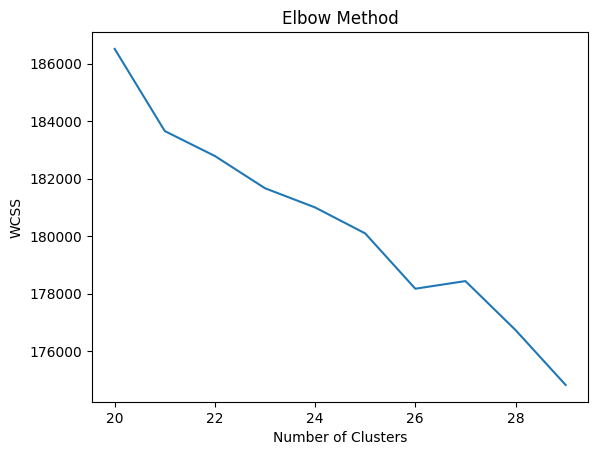

In [90]:


# Calculate Within-Cluster Sum of Squares (WCSS) for different number of clusters

start_time = time.time()

wcss = []
rg = range(20, 30)
for i in rg:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(encoded_features)
    wcss.append(kmeans.inertia_)
#start_time = time.time()
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")

# Plot the Elbow Method graph
plt.plot(rg, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Cluster with Tree Models/Forest (don't think will be too complicated)

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor


proj2_data_train = pd.read_csv(f'{path_to_data}/fold_{fldr_nb}/train.csv')
proj2_data_test = pd.read_csv(f'{path_to_data}/fold_{fldr_nb}/test.csv')


proj2_data_train,train_store, train_dept, train_date= data_processing(proj2_data_train)
proj2_data_test, test_store, test_dept, test_date = data_processing(proj2_data_test)

#do not use year
df = proj2_data_train[['Cate_Dept','Cate_Store','Weekly_Sales']]

no sales data


Time taken: 2.48 seconds


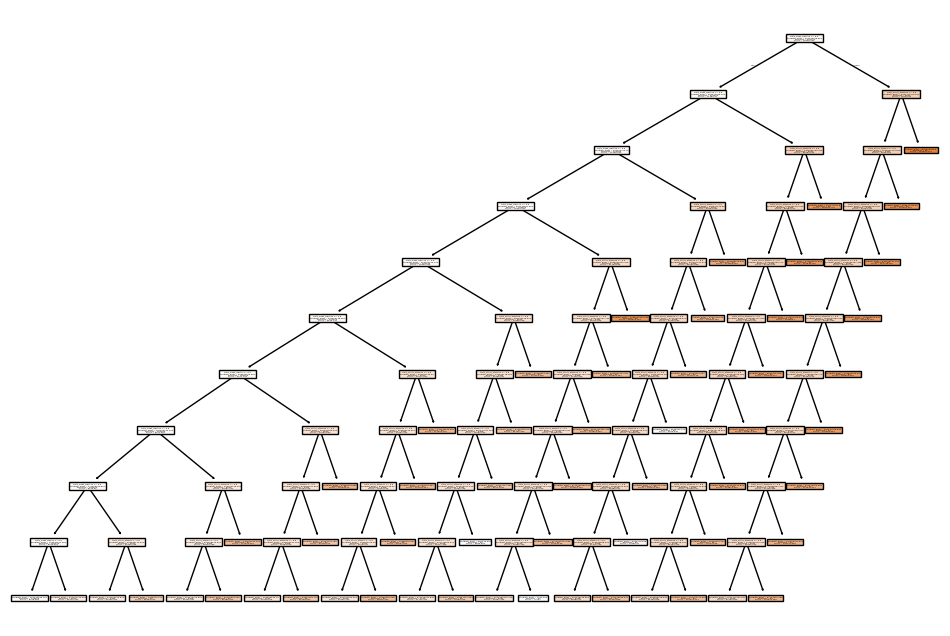

In [70]:
# Convert categorical columns to dummy variables
X = pd.get_dummies(df[['Cate_Dept','Cate_Store']], drop_first=True)
y = df['Weekly_Sales']

start_time = time.time()
# Fit a Decision Tree Regressor
regressor = DecisionTreeRegressor(random_state=42,max_depth=10)
regressor.fit(X, y)


end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")

# Plot the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(regressor, feature_names=X.columns, filled=True)
plt.show()

**Linear Model**

In [236]:
proj2_data_train = pd.read_csv(f'{path_to_data}/fold_1/train.csv')
proj2_data_test = pd.read_csv(f'{path_to_data}/fold_1/test.csv')


proj2_data_train,train_store, train_dept, train_date= data_processing(proj2_data_train)
proj2_data_test, test_store, test_dept, test_date = data_processing(proj2_data_test)

no sales data


In [237]:
proj2_data_train['Weekly_Sales'] = proj2_data_train['Weekly_Sales'].clip( lower=0,upper=50000)

In [238]:
#add segmentation code
proj2_data_train = proj2_data_train.merge(store_seg[['Cate_Store','store_perc_grp']], on='Cate_Store', how='left').merge(dept_seg[['Cate_Dept','dept_perc_grp']], on='Cate_Dept', how='left')

In [239]:
proj2_data_train['dept_perc_grp']

,dept_perc_grp
0,80.0
1,80.0
2,80.0
3,80.0
4,80.0
...,...
204115,20.0
204116,20.0
204117,20.0
204118,20.0


In [240]:
cov_mtx = proj2_data_train[[item for item in proj2_data_train.columns if (item.startswith('Wk_') or item == 'Weekly_Sales')]].astype('int').cov()



In [241]:
# check the cov of variables with weekly sales and thus get the most important variables
cov_mtx =cov_mtx.drop_duplicates()[['Weekly_Sales']]
cov_mtx['abs'] = abs(cov_mtx['Weekly_Sales'])
cov_mtx= cov_mtx.sort_values(by= 'abs', ascending=False)

In [242]:
cov_mtx

,Weekly_Sales,abs
Weekly_Sales,2.200092e+08,2.200092e+08
Wk_51,8.700168e+01,8.700168e+01
Wk_50,4.444148e+01,4.444148e+01
Wk_47,3.794319e+01,3.794319e+01
Wk_49,2.919789e+01,2.919789e+01
Wk_4,-2.782118e+01,2.782118e+01
Wk_2,-2.617329e+01,2.617329e+01
Wk_3,-2.539698e+01,2.539698e+01
Wk_8,-2.273628e+01,2.273628e+01
Wk_52,-1.909175e+01,1.909175e+01


In [243]:
#most important variables
#top variables are first dept then stores - seasonality not a strong impact while we know it should be
cov_mtx.index[1:10].tolist()

['Wk_51', 'Wk_50', 'Wk_47', 'Wk_49', 'Wk_4', 'Wk_2', 'Wk_3', 'Wk_8', 'Wk_52']

In [244]:
iv = cov_mtx.index[1:20].tolist() #most important variables
iv = iv+['IsHoliday','Yr','store_perc_grp','dept_perc_grp']

In [245]:
X = proj2_data_train[iv]
Y = proj2_data_train['Weekly_Sales']

In [246]:
import statsmodels.api as sm

In [247]:
X2 = sm.add_constant(X)
X2

,const,Wk_51,Wk_50,Wk_47,Wk_49,Wk_4,Wk_2,Wk_3,Wk_8,Wk_52,...,Wk_13,Wk_37,Wk_41,Wk_7,Wk_42,Wk_48,IsHoliday,Yr,store_perc_grp,dept_perc_grp
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2010,100.0,80.0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2010,100.0,80.0
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2010,100.0,80.0
3,1.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,2010,100.0,80.0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2010,100.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204115,1.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2011,20.0,20.0
204116,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2011,20.0,20.0
204117,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2011,20.0,20.0
204118,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2011,20.0,20.0


In [248]:

est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     9907.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        05:32:26   Log-Likelihood:            -2.1736e+06
No. Observations:              204120   AIC:                         4.347e+06
Df Residuals:                  204096   BIC:                         4.348e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.458e+05   2.09e+05      1.

In [17]:
for i in iv:
  try:
    proj2_data_test[i] = proj2_data_test[i].astype('int')
  except:
   proj2_data_test [i] = 0

In [18]:
X_test = proj2_data_test

In [19]:
X_test['const'] = 1

In [20]:
X_test
X2_test = X_test[['const']+iv]

In [21]:
y_fitted = est2.predict(X2_test)

In [22]:
proj2_data_test['lm_pred'] = y_fitted

In [23]:
proj2_data_test

,Date,IsHoliday,Yr,Cate_Dept,Cate_Store,weights,Wk_9,Wk_10,Wk_11,Wk_12,...,Wk_43,Wk_22,Wk_48,Wk_7,Wk_30,Wk_29,Wk_40,Wk_20,const,lm_pred
0,2011-03-04,0,2011,Dept1,Store1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,25335.552922
1,2011-03-11,0,2011,Dept1,Store1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,25335.552922
2,2011-03-18,0,2011,Dept1,Store1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,24796.637886
3,2011-03-25,0,2011,Dept1,Store1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,24562.066256
4,2011-04-01,0,2011,Dept1,Store1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,26287.682226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32395,2011-04-01,0,2011,Dept78,Store45,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-2307.091703
32396,2011-04-08,0,2011,Dept78,Store45,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-3259.221007
32397,2011-04-15,0,2011,Dept78,Store45,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-3259.221007
32398,2011-04-22,0,2011,Dept78,Store45,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-3867.963775


In [24]:
proj2_data_actual = pd.read_csv(f'{path_to_data}/test_with_label.csv')
proj2_data_actual,_,_,_ = data_processing(proj2_data_actual)

In [25]:
proj2_data_actual = proj2_data_actual.merge(proj2_data_test[[ 'Date','Cate_Store', 'Cate_Dept', 'lm_pred']], on=['Cate_Store', 'Cate_Dept'], how='left')
proj2_data_actual = proj2_data_actual[~(proj2_data_actual['lm_pred'].isna())]

#linear model results
lm_pred = sum(proj2_data_actual['weights'] * abs(proj2_data_actual['lm_pred'] - proj2_data_actual['Weekly_Sales'])) / sum(proj2_data_actual['weights'])
lm_pred

7704.288501901209

**tree model**

In [ ]:
proj2_data_train = pd.read_csv(f'{path_to_data}/fold_1/train.csv')
proj2_data_test = pd.read_csv(f'{path_to_data}/fold_1/test.csv')


proj2_data_train,train_store, train_dept, train_date= data_processing(proj2_data_train)
proj2_data_test, test_store, test_dept, test_date = data_processing(proj2_data_test)

In [ ]:
# Initialize the model

gb = GradientBoostingRegressor(n_estimators=500,random_state=42)

In [ ]:
gb.fit(proj2_data_train[iv], proj2_data_train['Weekly_Sales'])

In [ ]:
for i in iv:
  try:
    proj2_data_test[i] = proj2_data_test[i].astype('int')
  except:
   proj2_data_test [i] = 0

In [ ]:
y_pred_tree = gb.predict(proj2_data_test[iv])

In [ ]:
y_pred_tree

In [ ]:
proj2_data_test['tree_pred'] = y_pred_tree

In [ ]:
proj2_data_actual = pd.read_csv(f'{path_to_data}/test_with_label.csv')
proj2_data_actual,_,_,_ = data_processing(proj2_data_actual)

In [ ]:
proj2_data_actual = proj2_data_actual.merge(proj2_data_test[[ 'Date','Store', 'Dept', 'tree_pred']], on=[ 'Date','Store', 'Dept'], how='left')
proj2_data_actual = proj2_data_actual[~(proj2_data_actual['tree_pred'].isna())]

#linear model results
tree_pred = sum(proj2_data_actual['weights'] * abs(proj2_data_actual['tree_pred'] - proj2_data_actual['Weekly_Sales'])) / sum(proj2_data_actual['weights'])
tree_pred

**Naive Guess with Smooth**

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from scipy import stats
from scipy.optimize import minimize_scalar

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import SplineTransformer
from sklearn.cluster import KMeans


np.random.seed(3113)

In [ ]:
!pip install scikit-misc==0.3.1 #match the exact version from the reference, function output keywords slightly different
from skmisc.loess import loess
#from csaps import csaps

In [ ]:
"""
1- fit a loess model y1=x1 with span = sp, and extract
   the corresponding residual vector
2- call S_lam to obrain the diagonal entries of S
3- compute LOO-CV and GCV
"""
# Helper function to retrieve the diagonal of the smoother matrix S
def S_lam(x, span):
# Fit a LOESS model with a fake y vector (diagonal entries of S are independent of y)
    n = len(x)
    S_diag = np.zeros(n)

    # Loop through each point and perturb the y values slightly
    for i in range(n):
        # Perturb the i-th point
        y_perturbed = np.zeros(n)
        y_perturbed[i] = 1

        # Fit LOESS model with perturbed y
        loess_fit = loess(x, y_perturbed, span=span)
        loess_fit.fit()

        # Predict values (fitted values will form one row of S)
        S_diag[i] = loess_fit.predict(x).values[i]

    return S_diag


In [ ]:
def loo_cv(x, y, span):
    """
    Compute the Leave-One-Out Cross-Validation (LOO-CV) for a given span.

    Inputs:
    - x: an n-by-1 feature vector (input data)
    - y: target values
    - span: a numerical value representing the span for LOESS

    Output:
    - LOO-CV error
    """
    loess_fit = loess(x, y, span=span)
    loess_fit.fit()
    y_pred = loess_fit.predict(x).values
    residuals = y - y_pred
    S_diag = S_lam(x, span)

    # Compute LOO-CV error
    loo_errors = residuals / (1 - S_diag)
    loo_cv_error = np.mean(loo_errors**2)

    return loo_cv_error

def gcv(x, y, span):
    """
    Compute the Generalized Cross-Validation (GCV) for a given span.

    Inputs:
    - x: an n-by-1 feature vector (input data)
    - y: target values
    - span: a numerical value representing the span for LOESS

    Output:
    - GCV error
    """
    loess_fit = loess(x, y, span=span)
    loess_fit.fit()
    y_pred = loess_fit.predict(x).values
    residuals = y - y_pred
    S_diag = S_lam(x, span)

    # Effective degrees of freedom
    edf = np.sum(S_diag)

    # Compute GCV error
    gcv_error = np.mean(residuals**2) / ((1 - edf / len(x))**2)

    return gcv_error

def find_optimal_span(x, y, span_values):
    """
    Find the optimal span based on CV and GCV.

    Inputs:
    - x: an n-by-1 feature vector (input data)
    - y: target values
    - span_values: a list of span values to test

    Output:
    - cv_errors: list of LOO-CV errors for each span
    - gcv_errors: list of GCV errors for each span
    - best_span: span with the lowest CV and GCV errors
    """
    cv_errors = []
    gcv_errors = []

    for span in span_values:
        cv_error = loo_cv(x, y, span)
        gcv_error = gcv(x, y, span)
        cv_errors.append(cv_error)
        gcv_errors.append(gcv_error)

    # Find the best span based on the minimum CV error
    best_span = span_values[np.argmin(cv_errors)]

    return cv_errors, gcv_errors, best_span


In [ ]:
def plot_results(x, y, best_span):
    """
    Plot the original data points and fitted curve using the optimal span.

    Inputs:
    - x: feature vector
    - y: target values
    - best_span: the optimal span for LOESS
    """
    loess_fit = loess(x, y, span=best_span)
    loess_fit.fit()

    # Generate a finer grid for plotting a smooth curve
    #x_fine = np.linspace(min(x), max(x), 500)
    y_fitted = loess_fit.predict(x).values

    # Plot original data points and fitted curve
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='Original data', color='gray', s=50, facecolor='none')
    plt.plot(x, y_fitted, label='Fitted LOESS Curve', color='blue', linewidth=2, linestyle='--')

    # True curve: f(x) = sin(12*(x+0.2))/(x+0.2)
    #true_curve = np.sin(12 * (x_fine + 0.2)) / (x_fine + 0.2)
    #plt.plot(x_fine, true_curve, label='True Curve', color='grey')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title(f'LOESS with optimal span {best_span}')
    plt.show()



In [ ]:
np.around(np.linspace(0.1, 0.2, 15),3)

In [ ]:
span_values = np.around(np.linspace(0.1, 0.9, 15),2)
span_values[2:3]

In [ ]:

span_values = np.around(np.linspace(0.1, 0.9, 15),2)
best_smooth_naive_pred= 9999999
span = 0.33
folder = 1
#for folder in range(1,11):

for span in span_values:

  proj2_data_train = pd.read_csv(f'{path_to_data}/fold_1/train.csv')
  proj2_data_test = pd.read_csv(f'{path_to_data}/fold_1/test.csv')

  #proj2_data_train = pd.read_csv(f'{path_to_data}/fold_{folder}/train.csv')
  #proj2_data_test = pd.read_csv(f'{path_to_data}/fold_{folder}/test.csv')

  proj2_data_train,train_store, train_dept, train_date= data_processing(proj2_data_train)
  proj2_data_test, test_store, test_dept, test_date = data_processing(proj2_data_test)
  train_to_future=pd.DataFrame()

  for s_i, store in enumerate(train_store['Store'].tolist()):
    for d_i, dept in enumerate(train_dept['Dept'].tolist()):
      tmp_train = proj2_data_train[(proj2_data_train['Store']==store) & (proj2_data_train['Dept']==dept)]
      y = tmp_train['Weekly_Sales'].values
      x = tmp_train['Date'].values



      # Define span values
      #span_values = np.around(np.linspace(0.2, 0.9, 15),2)


      # Find optimal span
      #cv_errors, gcv_errors, best_span = find_optimal_span(x, y, span_values)

      loess_fit = loess(x, y, span=span) # almost like a winzorization
      loess_fit.fit()
      y_fitted = loess_fit.predict(x).values

      tmp_train['Smooth_Weekly_Sales'] = y_fitted

      tmp_train_to_future = tmp_train
      tmp_train_to_future['Yr'] = tmp_train['Yr']+1
      tmp_train_to_future['naive_pred'] = tmp_train['Weekly_Sales']
      tmp_train_to_future['smooth_naive_pred'] = tmp_train['Smooth_Weekly_Sales']

      try:
        train_to_future = pd.concat([train_to_future, tmp_train_to_future])
      except:
        train_to_future = tmp_train_to_future

  proj2_data_actual = pd.read_csv(f'{path_to_data}/test_with_label.csv')
  proj2_data_actual, actual_store, actual_dept, actual_date = data_processing(proj2_data_actual)

  proj2_data_actual = proj2_data_actual.merge(train_to_future[[ 'Yr','Wk','Store', 'Dept','smooth_naive_pred']], on=['Yr','Wk','Store','Dept'], how='left')

  proj2_data_actual = proj2_data_actual[~(proj2_data_actual['smooth_naive_pred'].isna())]
  #naive prediction results
  smooth_naive_pred = sum(proj2_data_actual['weights'] * abs(proj2_data_actual['smooth_naive_pred'] - proj2_data_actual['Weekly_Sales'])) / sum(proj2_data_actual['weights'])
  if smooth_naive_pred < best_smooth_naive_pred:
    best_smooth_naive_pred = smooth_naive_pred
  print(f'in folder {folder}, when span = {span}, reach smooth_naive_pred = {smooth_naive_pred}')




In [ ]:
for i in range(1,11):
  print(i)

In [ ]:
train_to_future

**SUMMARY**

In [ ]:

print(f'naive_pred: {naive_pred}')
print(f'tree_pred: {tree_pred}')
print(f'lm_pred: {lm_pred}')
print(f'smooth_naive_pred: {best_smooth_naive_pred}')

===================== code archive ===========================================

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score


proj2_data_train = pd.read_csv(f'{path_to_data}/fold_1/train.csv')
proj2_data_test = pd.read_csv(f'{path_to_data}/fold_1/test.csv')


proj2_data_train,train_store, train_dept, train_date= data_processing(proj2_data_train)
proj2_data_test, test_store, test_dept, test_date = data_processing(proj2_data_test)

#do not use year
df_km = proj2_data_train[['Cate_Dept','Cate_Store','Weekly_Sales']]

# One-Hot Encoding for categorical independent variables
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df_km [['Cate_Dept','Cate_Store']])

# Calculate Within-Cluster Sum of Squares (WCSS) for different number of clusters

start_time = time.time()

wcss = []
rg = range(45, 65)
for i in rg:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(encoded_features)
    wcss.append(kmeans.inertia_)
#start_time = time.time()
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")

# Plot the Elbow Method graph
plt.plot(rg, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()